<a href="https://colab.research.google.com/github/manabil/Tensorflow-Advanced-Techniques-Specialization/blob/main/Custom%20Models%2C%20Layers%2C%20Loss%20Functions%20with%20Tensorflow/Week%205/C1_W5_Lab_2_custom_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Keras custom callbacks
A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Towards the end of this guide, there will be demos of creating a couple of simple callback applications to get you started on your custom callback.

## Imports

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import io

from datetime import datetime
from typing import Optional
from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.12.0


In [27]:
# Define the Keras model to add callbacks to
def get_model() -> tf.keras.Sequential:
    model: tf.keras.Sequential = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

Then, load the MNIST data for training and testing from Keras datasets API:

In [28]:
# Load example MNIST data and pre-process it
y_train: np.ndarray
y_test: np.ndarray
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train: np.ndarray = x_train.reshape(60000, 784).astype('float32') / 255
x_test: np.ndarray = x_test.reshape(10000, 784).astype('float32') / 255

Now, define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch.

In [29]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(
        self, batch: int, logs: Optional[dict]=None
    ) -> None:
        print(f'Training: batch {batch} begins at {datetime.now().time()}')

    def on_train_batch_end(
        self, batch: int, logs: Optional[dict]=None
    ) -> None:
        print(f'Training: batch {batch} ends at {datetime.now().time()}')

Providing a callback to model methods such as `tf.keras.Model.fit()` ensures the methods are called at those stages:

In [30]:
model: tf.keras.Sequential = get_model()
_: tf.keras.callbacks.History = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=1,
    steps_per_epoch=5,
    verbose=0,
    callbacks=[MyCustomCallback()]
)

Training: batch 0 begins at 00:27:36.566864
Training: batch 0 ends at 00:27:36.906057
Training: batch 1 begins at 00:27:36.907213
Training: batch 1 ends at 00:27:36.909056
Training: batch 2 begins at 00:27:36.909819
Training: batch 2 ends at 00:27:36.911173
Training: batch 3 begins at 00:27:36.911920
Training: batch 3 ends at 00:27:36.913250
Training: batch 4 begins at 00:27:36.913890
Training: batch 4 ends at 00:27:36.915068


## An overview of callback methods


### Common methods for training/testing/predicting
For training, testing, and predicting, following methods are provided to be overridden.
#### `on_(train|test|predict)_begin(self, logs=None)`
Called at the beginning of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_end(self, logs=None)`
Called at the end of `fit`/`evaluate`/`predict`.
#### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
Called right before processing a batch during training/testing/predicting. Within this method, `logs` is a dict with `batch` and `size` available keys, representing the current batch number and the size of the batch.
#### `on_(train|test|predict)_batch_end(self, batch, logs=None)`
Called at the end of training/testing/predicting a batch. Within this method, `logs` is a dict containing the stateful metrics result.

### Training specific methods
In addition, for training, following are provided.
#### `on_epoch_begin(self, epoch, logs=None)`
Called at the beginning of an epoch during training.
#### `on_epoch_end(self, epoch, logs=None)`
Called at the end of an epoch during training.


### Usage of `logs` dict
The `logs` dict contains the loss value, and all the metrics at the end of a batch or epoch. Example includes the loss and mean absolute error.

In [31]:
def delta_loss(epoch: int, logs: Optional[dict]=None) -> None:
    delta: float = logs["val_loss"] / logs["loss"]
    print(f"Epoch: {epoch}, Val/Train loss ratio: {delta:.2f}")

callback: tf.keras.callbacks.Callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=delta_loss
)

model: tf.keras.Sequential = get_model()
_: tf.keras.callbacks.History = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=3,
    verbose=0,
    callbacks=[callback]
)

Epoch: 0, Val/Train loss ratio: 1.98
Epoch: 1, Val/Train loss ratio: 0.34
Epoch: 2, Val/Train loss ratio: 1.05


In [34]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold: float=0.7) -> None:
        super(DetectOverfittingCallback, self).__init__()
        self.threshold: float = threshold

    def on_epoch_end(self, epoch: int, logs: Optional[dict]=None):
        ratio: float = logs["val_loss"] / logs["loss"]
        print(f"Epoch: {epoch}, Val/Train loss ratio: {ratio:.2f}")

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model: tf.keras.Sequential = get_model()
_: tf.keras.callbacks.History = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=3,
    verbose=0,
    callbacks=[DetectOverfittingCallback()]
)

Epoch: 0, Val/Train loss ratio: 0.28
Epoch: 1, Val/Train loss ratio: 1.34
Stopping training...


Similarly, one can provide callbacks in `evaluate()` calls.

## Custom callback to Visualize predictions

In [35]:
# Load example MNIST data and pre-process it
y_train: np.ndarray
y_test: np.ndarray
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train: np.ndarray = x_train.reshape(60000, 784).astype('float32') / 255
x_test: np.ndarray = x_test.reshape(10000, 784).astype('float32') / 255

In [51]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(
    inputs: np.ndarray,
    outputs: np.ndarray,
    ground_truth: np.ndarray,
    epoch: int,
    n: int=10
) -> None:
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]:
            t.set_color('green')
        else:
            t.set_color('red')
    plt.grid(None)

In [37]:
GIF_PATH: str = './animation.gif'

In [57]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(
        self,
        inputs: np.ndarray,
        ground_truth: np.ndarray,
        display_freq: int=10,
        n_samples: int=10
    ) -> None:
        self.inputs: np.ndarray = inputs
        self.ground_truth: np.ndarray = ground_truth
        self.images: list = []
        self.display_freq: int = display_freq
        self.n_samples: int = n_samples

    def on_epoch_end(self, epoch: int, logs: Optional[dict]=None) -> None:
        # Randomly sample data
        len_input: int = len(self.inputs)
        indexes: np.ndarray = np.random.choice(len_input, self.n_samples)
        X_test: np.ndarray
        y_test: np.ndarray
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions: np.ndarray = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf: io.BytesIO = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image: Image.Image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs: Optional[dict]=None) -> None:
        imageio.mimsave(GIF_PATH, self.images, duration=1000)

In [58]:
def get_model() -> tf.keras.Sequential:
    model: tf.keras.Sequential = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

1/1 [==============================] - 0s 46ms/step


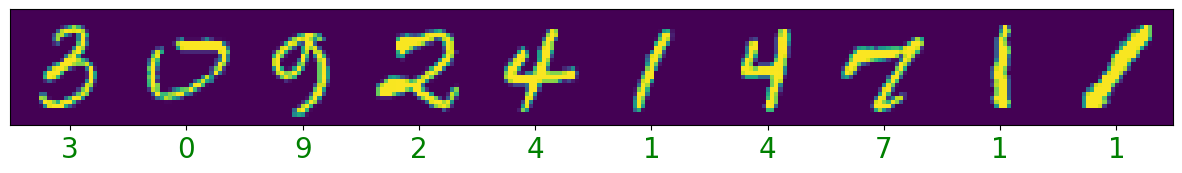

1/1 [==============================] - 0s 30ms/step


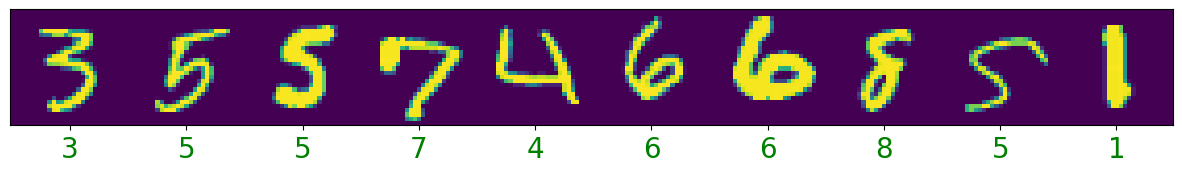

1/1 [==============================] - 0s 20ms/step


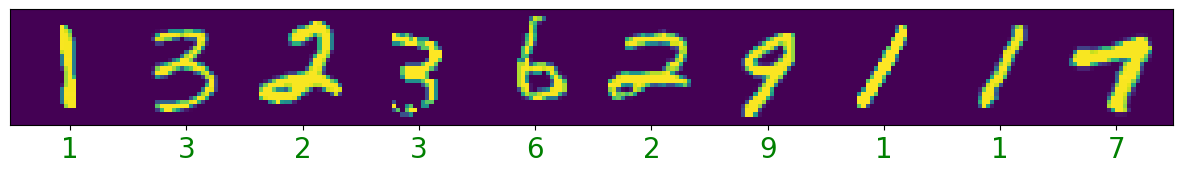

In [59]:
model: tf.keras.Sequential = get_model()
model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    verbose=0,
    callbacks=[VisCallback(x_test, y_test)]
)

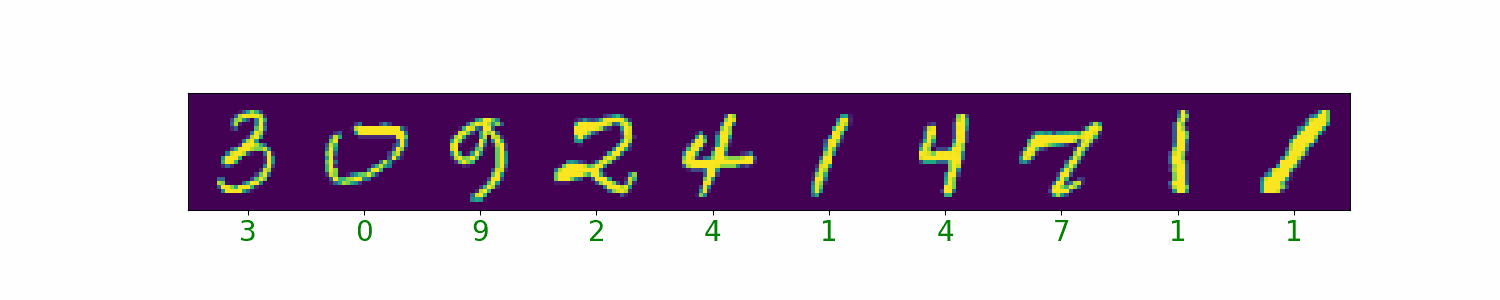

In [60]:
SCALE: int = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15*SCALE, height=3*SCALE)